HsMM-MVpy
==========

![](plots/general_illustration.png)

hsmm_mvpy is an open-source Python package to estimate Hidden Semi-Markov Models in a Multivariate Pattern Analysis (HsMM-MVPA) of electro-encephalographic (EEG) data based on the method developed by Anderson, Zhang, Borst, & Walsh  ([2016](https://psycnet.apa.org/doi/10.1037/rev0000030)), Borst & Anderson ([2021](http://jelmerborst.nl/pubs/ACTR_HsMM_MVPA_BorstAnderson_preprint.pdf)) and Weindel, van Maanen & Borst (in preparation).

As a summary of the method, an HsMM-MVPA analysis parses the EEG into a number of significant cognitive event (called bumps) separated by flat period reflecting the ongoing stage initiated by a bump. Hence any reaction time can then be described by the number of bumps and stage estimated using hsmm_mvpy. The important aspect of HsMM-MVPA is that it is a whole-brain analysis (or whole scalp analysis) that estimates the onset of cognitive events on a single-trial basis. This by-trial estimations allows you then to further dig into any aspect you are interested in the EEG (or MEG) signal:
- Describing an experiment or a clinical sample in terms of processes detected in the EEG signal
- Describing experimental effects based on a particular stage duration
- Estimating the effect of trial-wise manipuations (e.g. the by-trial variation of stimulus strength or the effect of time-on-task)
- Time-lock EEG signal to the onset of a given bump and perform classical ERPs or time-freauency analysis based on the events that are the estimated bumps
- And many more (e.g. evidence accumulation models on decision stage, classification based on the number of events in the signal,...)


# Documentation

The package is available through *pip* with the command ```pip install hsmm_mvpy```. 
A recommended way of using the package is to use a conda environment (see [anaconda](https://www.anaconda.com/products/distribution>) for how to install conda):

    $ conda create -n hsmm 
    $ conda activate hsmm
    $ conda install pip #optional for windows machine
    $ pip install hsmm_mvpy

Then import hsmm-mvpy in your favorite python IDE through:

```python
    import hsmm_mvpy as hsmm
```

For the cutting edge version (not recommended) you can clone the repository using *git*

Open a terminal and type:

    $ git clone https://github.com/gweindel/hsmm_mvpy.git
   
Then move to the clone repository and run 
    
    $ pip install -e .

## To get started
To get started with the code:
- Check the demo below 
- Inspect the tutorials in the tutorials repository
    - Load EEG data (tutorial 1)
    - Estimating a given number of bumps (tutorial 2)
    - Test for the number of bumps that best explains the data (tutorial 3)
    - Testing differences across conditions (tutorial 4)

To further learn about the method be sure to check the paper by Anderson, Zhang, Borst, & Walsh  ([2016](https://psycnet.apa.org/doi/10.1037/rev0000030)) as well as the book chapter by Borst & Anderson ([2021](http://jelmerborst.nl/pubs/ACTR_HsMM_MVPA_BorstAnderson_preprint.pdf)). The following list also contains a non-exhaustive list of papers published using the HsMM-MVPA method:
- Berberyan, H. S., van Maanen, L., van Rijn, H., & Borst, J. (2021). EEG-based identification of evidence accumulation stages in decision-making. Journal of Cognitive Neuroscience, 33(3), 510-527. [link](https://doi.org/10.1162/jocn_a_01663)
- Van Maanen, L., Portoles, O., & Borst, J. P. (2021). The discovery and interpretation of evidence accumulation stages. Computational brain & behavior, 4(4), 395-415. [link](https://link.springer.com/article/10.1007/s42113-021-00105-2)
- Portoles, O., Blesa, M., van Vugt, M., Cao, M., & Borst, J. P. (2022). Thalamic bursts modulate cortical synchrony locally to switch between states of global functional connectivity in a cognitive task. PLoS computational biology, 18(3), e1009407. [link](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1009407)

## Demo on simulated data

The following section will quickly walk you through an example usage in simulated data (using [MNE](https://mne.tools/dev/auto_examples/simulation/index.html)'s simulation functions and tutorials)

First we load the libraries necessary for the demo on simulated data

### Importing libraries

In [2]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mne import channels

## Importing 
import hsmm_mvpy as hsmm
from hsmm_mvpy import simulations

### Simulating data

In the following code block we simulate 30 trials from four known sources, this is not code you would need for your own analysis except if you want to simulate and test properties of HsM models. All these four sources are defined by a localization, an activation amplitude and a distribution (here gamma with shape and scale parameters) for the onsets of the bumps on each trial. The simulation functions are based on the [MNE tutorial ](https://mne.tools/stable/auto_examples/simulation/simulated_raw_data_using_subject_anatomy.html).

_If you're running this for the first time a 1.65 G file will be downloaded in order to perform the simulation but this will be done only once_


In [3]:
cpus = 5 # For multiprocessing, usually a good idea to use multiple CPus as long as you have enough RAM
path = os.path.join('simulated/')#Where simulated data will go, create that folder if you don't have it where you're executing the code

n_events = 30 #Number of trials to simulate

sources = [['superiorparietal-rh',6e-9, [np.random.gamma,2,40]],#One source = localization, acitvation amplitude and onset latencies
           ['postcentral-lh', 5e-9, [np.random.gamma, 2, 90]],
           ['posteriorcingulate-rh', 5e-9, [np.random.gamma, 2,50]],
           ['postcentral-rh', 5e-9, [np.random.gamma, 2,170]],
           ['postcentral-lh', 1e-20, [np.random.gamma, 2,25]]] #Equivalent to a response trigger as amplitude make it hardly visible

max_trial_length = 3000 #length of a trial (ISI)

bump_frequency = 10. #Frequency of the simulated bumps
file = 'dataset_tutorial' #Name of the file to save
mne_path = os.path.join(path+file+'_raw.fif')

raw, generating_events = simulations.simulate(sources, n_events, max_trial_length, cpus, bump_frequency, file, path, overwrite=False)
positions = np.delete(channels.layout._find_topomap_coords(raw.info, 'eeg'),52,axis=0)#inferring electrode location using MNE

Aligning file name to MNE's convention
Simulating dataset_tutorial_raw.fif in simulated/
Overwriting existing file.
Writing /home/gweindel/owncloud/projects/RUGUU/hsmm-mvpy/simulated/dataset_tutorial_raw.fif
Closing /home/gweindel/owncloud/projects/RUGUU/hsmm-mvpy/simulated/dataset_tutorial_raw.fif
[done]
simulated/dataset_tutorial_raw.fif simulated


### Creating the event structure and plotting the raw data


To recover the data we need to create the event structure based on the triggers sent during simulation. This is the same as analyzing real EEG data and recovering events in the stimulus channel. In our case 0 signal the onset of the stimulus and 5 the onset of the response. Hence a trial is defined as the times occuring between the triggers 0 and 5.

In [4]:
%matplotlib inline

resp_trigger = int(np.max(np.unique(generating_events[:,2])))#Resp trigger is the last source in each trial
event_id = {'stimulus':1}
resp_id = {'response':resp_trigger}
events = generating_events[(generating_events[:,2] == 1) | (generating_events[:,2] == resp_trigger)]#only retain stimulus and response triggers

raw.pick_types(eeg=True).plot(scalings=dict(eeg=1e-5), events=events);

Removing projector <Projection | PCA-v1, active : True, n_channels : 102>
Removing projector <Projection | PCA-v2, active : True, n_channels : 102>
Removing projector <Projection | PCA-v3, active : True, n_channels : 102>
Using qt as 2D backend.
Opening raw-browser...


In [5]:
raw

<RawArray | 59 x 105000 (174.8 s), ~50.2 MB, data loaded>

### Recovering number of sources as well as actual by-trial variation

To compare the by-trial duration of bumps that we will estimate later on we first recover the actual number of sources used in the simulation as well as the actual by-trial variation in the onset of the bumps. Again with a typical dataset you wouldn't need that part as you ignore the ground truth

In [6]:
number_of_sources = len(np.unique(generating_events[:,2])[1:])#one trigger = one source
random_source_times = np.zeros((int(len(generating_events)/(number_of_sources+1)), number_of_sources))

i,x = 1,0                  
while x < len(random_source_times):
    for j in np.arange(number_of_sources):#recovering the individual duration- of bump onset
        random_source_times[x,j] = generating_events[i,0] - generating_events[i-1,0]
        i += 1
    i += 1
    x += 1

## Demo of the HsMM Code for a single participant in a single condition based on the simulated data

First we read the EEG data as we would for a single participant:

In [7]:
# Reading the data
eeg_dat = hsmm.utils.read_mne_EEG(mne_path, event_id, resp_id, raw.info['sfreq'], events_provided=events, verbose=False)


Processing participant simulated/dataset_tutorial_raw.fif
Reading 0 ... 104999  =      0.000 ...   174.819 secs...
Creating epochs based on following event ID :[1 6]
N trials without response event: 0
Applying reaction time trim to keep RTs between 0.001 and 5 seconds
30 RTs kept of 30 clean epochs
30 trials were retained for participant simulated/dataset_tutorial_raw.fif
End sampling frequency is 600.614990234375 Hz


The package uses [xarray](https://docs.xarray.dev/en/stable/) named dimension matrices, allowing to directly manipulate the data using the name of the dimensions:

<xarray.Dataset>
Dimensions:      (participant: 1, epochs: 30, electrodes: 59, samples: 1116)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 8 ... 21 22 23 24 25 26 27 28 29
  * electrodes   (electrodes) <U7 'EEG 001' 'EEG 002' ... 'EEG 059' 'EEG 060'
  * samples      (samples) int64 0 1 2 3 4 5 6 ... 1110 1111 1112 1113 1114 1115
  * participant  (participant) <U2 'S0'
Data variables:
    data         (participant, epochs, electrodes, samples) float64 -1.045e-0...
    event        (participant, epochs) <U8 'stimulus' 'stimulus' ... 'stimulus'
Attributes:
    sfreq:    600.614990234375


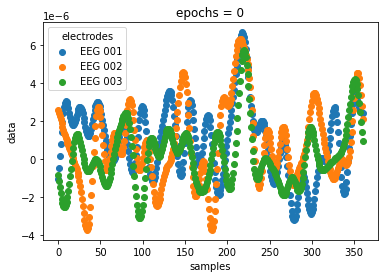

In [8]:
#example of usage of xarray
print(eeg_dat)
eeg_dat.sel(epochs=0,electrodes=['EEG 001','EEG 002','EEG 003']).plot.scatter(x='samples', y='data',hue='electrodes');

Next we transform the data as in Anderson, Zhang, Borst, & Walsh  ([2016](https://psycnet.apa.org/doi/10.1037/rev0000030)) including standardization of individual variances (not in this case as we have only one simulated participant), z-scoring and spatial principal components analysis (PCA). 

Note that if the number of components to retain is not specified, the scree plot of the PCA is displayed and a prompt ask how many PCs should be retained (in this case we specify it as building the README does not allow for prompts)

In [9]:
hsmm_dat = hsmm.utils.transform_data(eeg_dat.data, apply_standard=False, single=True, n_comp=5)

hsmm_dat = hsmm.utils.stack_data(hsmm_dat)

# Estimating an HsMM model

We know that we generate from four sources so let's just try to recover those four sources by directly estimating a 4 bump model (see tutorial 2 for the explanation of the following cell)

In [10]:
init = hsmm.models.hsmm(hsmm_dat, sf=eeg_dat.sfreq, bump_width=50, cpus=cpus)#Initialization of the model

selected = init.fit_single(number_of_sources-1, starting_points=25)#function to fit an instance of a 4 bumps model with 25 random starting points for the expectation maximization algorithm

Estimating 4 bumps model with 24 random starting points
Parameters estimated for 4 bumps model


### Visualizing results of the fit

In the previous cell we initiated an HsMM model looking for 50ms bumps in the EEG signal and parsing the EEG data into a signal with 4 bumps and 5 gamma distributed stages with a fixed shape of 2 and a scale estimated by stage. We can now inspect the results of the fit

We can directly take a look to the topologies and latencies of the bumps by calling ```hsmm.visu.plot_topo_timecourse```

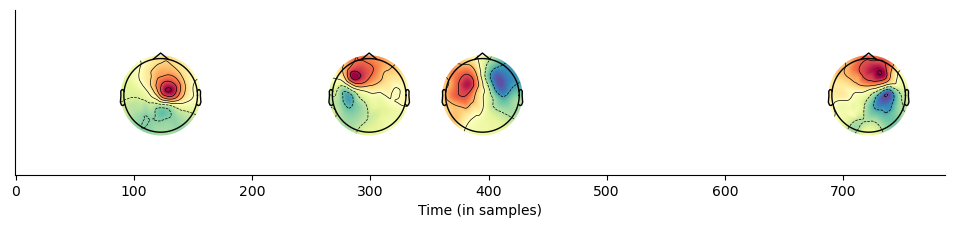

In [11]:
hsmm.visu.plot_topo_timecourse(eeg_dat, selected, positions, 
                               bump_size=init.bump_width_samples, magnify=5, figsize=(12,2), sensors=False,
                                time_step = 1,  times_to_display = np.mean(init.ends - init.starts))

This shows us the electrode activity on the scalp as well as the average time of occurence of the bump based on the stage distributions.

As we are estimating the bump onsets on a by-trial basis we can look at the by-trial variation in stage duration.

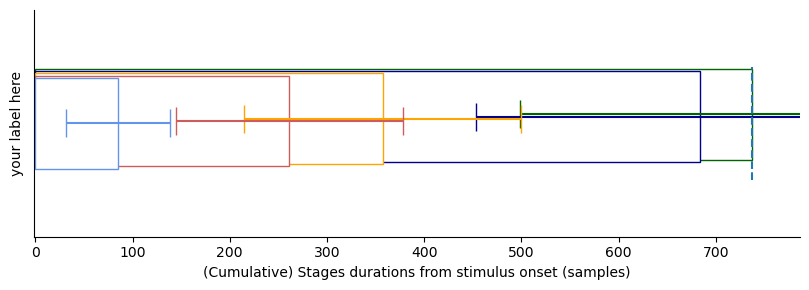

In [12]:
bump_times_selected = init.bump_times(selected.eventprobs, mean=False)#computing predicted bump times

ax = hsmm.visu.plot_latencies_average(bump_times_selected, init.bump_width_samples, 1, errs='std', times_to_display = np.mean(init.ends - init.starts))
ax.set_ylabel('your label here');

For the same reason we can also inspect the probability distribution of bump onsets:

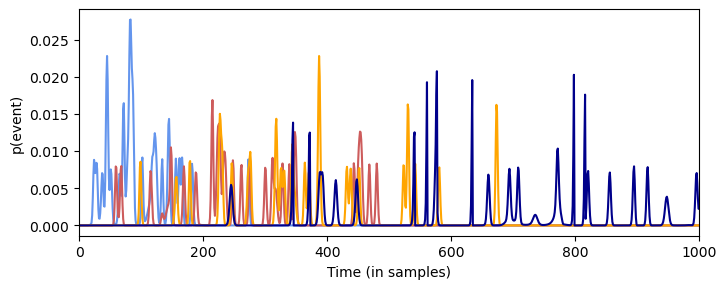

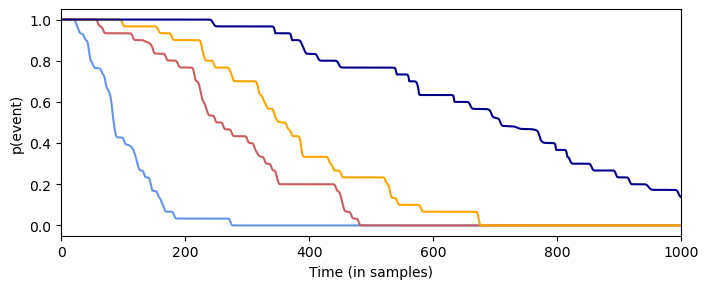

In [13]:
hsmm.visu.plot_distribution(selected.eventprobs.mean(dim=['trial_x_participant']), xlims=(0,1000))
hsmm.visu.plot_distribution(selected.eventprobs.mean(dim=['trial_x_participant']), xlims=(0,1000), survival=True);

As HsMM-MVPA selected those bumps onset per trial we can also look at the predicted bump onsets for a single trial

<AxesSubplot:xlabel='Time (in samples)', ylabel='p(event)'>

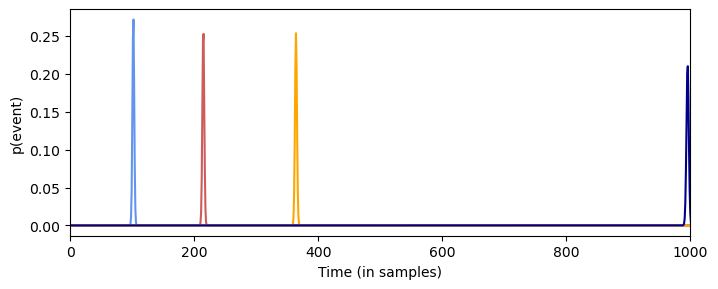

In [14]:
hsmm.visu.plot_distribution(selected.eventprobs.sel(trial_x_participant=('S0', 1)), xlims=(0,1000))

This then shows the likeliest bump location in time for the first trial!

## Comparing with ground truth

As we simulated the data we have access to the ground truth of the underlying generative events. We can then compare the average stage durations compared to the one estimated by HsMM-MVpy. As in the beginning, this code is specific to the case where you simulate data.

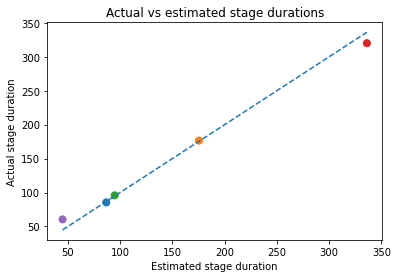

In [15]:
colors = sns.color_palette(None, number_of_sources)
plt.scatter(np.mean(random_source_times, axis=0), selected.parameters.dropna('stage').isel(params=1)*2+np.concatenate([[0],np.repeat(init.bump_width_samples,number_of_sources-1)]), color=colors,s=50)
plt.plot([np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],
         [np.min(np.mean(random_source_times,axis=0)),np.max(np.mean(random_source_times,axis=0))],'--');
plt.title('Actual vs estimated stage durations')
plt.xlabel('Estimated stage duration')
plt.ylabel('Actual stage duration')
plt.show()


Or also overlay actual bumps onset with predicted one

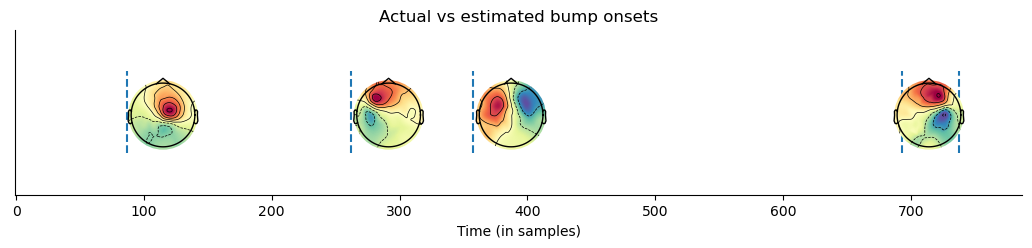

In [16]:
hsmm.visu.plot_topo_timecourse(eeg_dat, selected, positions,sensors=False,
        bump_size=init.bump_width_samples, time_step = 1, magnify=4, figsize=(13,2), title='Actual vs estimated bump onsets',
        times_to_display = np.mean(np.cumsum(random_source_times,axis=1),axis=0))

We see that the HsMM-MVpy package recovers the exact average location of the bumps defined in the simulated data

We can further test how well the package did by comparing the generated single trial onsets with those estimated from the HsMM model

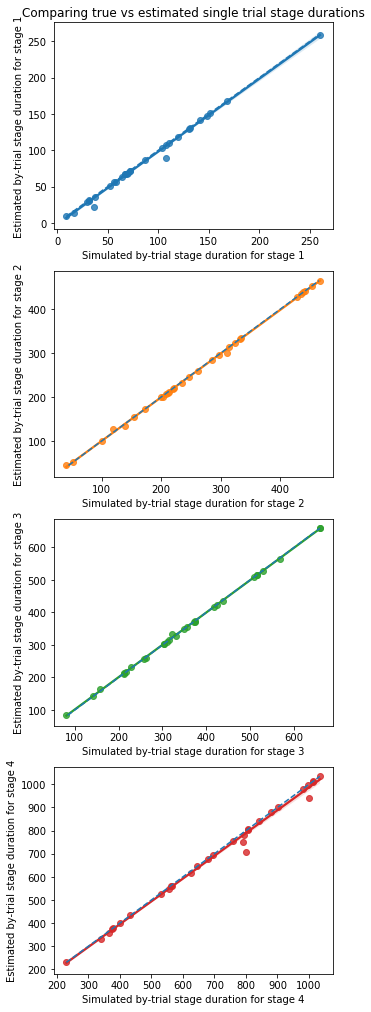

In [17]:
fig, ax= plt.subplots(number_of_sources-1,1, figsize=(5,3.5*number_of_sources))
ax[0].set_title('Comparing true vs estimated single trial stage durations')
i = 0
gen_bump_location = np.cumsum(random_source_times[:,:-1], axis=1)
for bump in init.bump_times(selected.eventprobs, mean=False)[:,:number_of_sources-1].T:
    sns.regplot(x=gen_bump_location[:,i].T, y=bump, ax=ax[i], color=colors[i])
    ax[i].plot([np.min(bump), np.max(bump)], [np.min(bump), np.max(bump)],'--')
    ax[i].set_ylabel(f'Estimated by-trial stage duration for stage {i+1}')
    ax[i].set_xlabel(f'Simulated by-trial stage duration for stage {i+1}')
    i+= 1

We see that, to the exception of the first stage, every other stage gets nicely recovered even on a by-trial basis!

### Follow-up

For examples on how to use the package when the number of bumps are unkown, or to compare stage durations across conditions see the tutorial notebooks:
- Load EEG data (tutorial 1)
- Estimating a given number of bumps (tutorial 2)
- Test for the number of bumps that best explains the data (tutorial 3)
- Testing differences across conditions (tutorial 4)